# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import Model, layers, Sequential, losses, optimizers, regularizers
from keras import callbacks

# Load Datasets

In [36]:
X_train = pickle.load(open("../data/pickle/X_train.pkl", "rb"))
y_train = pickle.load(open("../data/pickle/y_train_encoded.pkl", "rb"))

X_test = pickle.load(open("../data/pickle/X_test.pkl", "rb"))
y_test = pickle.load(open("../data/pickle/y_test_encoded.pkl", "rb"))

IMG_SHAPE = (48, 48, 3)
n_class = 7

# Create Custom CNN Model

## Data Augmentation

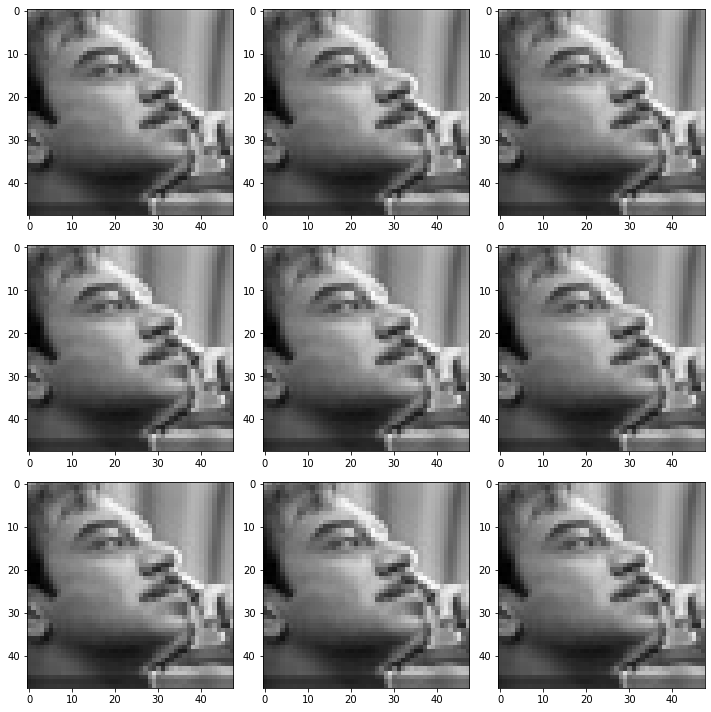

In [39]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical", name = "flip"),
    layers.RandomRotation(0.2, name = "rotate"),
], name = "augmentation")

plt.figure(figsize = (10, 10))
first_image = X_train[3]
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0])

plt.tight_layout()
plt.savefig("../plot/augmentation.pdf", format = "pdf")

## CNN Model

In [5]:
kernel_size = [64, 128, 256, 512, 512]
dense_size = [4096, 4096]

CNN = Sequential(
    [
        layers.InputLayer(input_shape = IMG_SHAPE),
        data_augmentation,

        # block 1
        layers.Conv2D(kernel_size[0], (3, 3), padding = "same", activation = "relu", name = "block1_conv1"),
        layers.Conv2D(kernel_size[0], (3, 3), padding = "same", activation = "relu", name = "block1_conv2"),
        layers.BatchNormalization(name = "block1_normalizer"),
        layers.MaxPooling2D((2, 2), strides=(2, 2), name = "block1_pool"),
        # layers.Dropout(0.25),

        # block 2
        layers.Conv2D(kernel_size[1], (3, 3), padding = "same", activation = "relu", name = "block2_conv1", kernel_regularizer=regularizers.l2(0.01)),
        layers.Conv2D(kernel_size[1], (3, 3), padding = "same", activation = "relu", name = "block2_conv2", kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(name = "block2_normalizer"),
        layers.MaxPooling2D((2, 2), strides=(2, 2), name = "block2_pool"),
        # layers.Dropout(0.25),

        # block 3
        layers.Conv2D(kernel_size[2], (3, 3), padding = "same", activation = "relu", name = "block3_conv1", kernel_regularizer=regularizers.l2(0.01)),
        layers.Conv2D(kernel_size[2], (3, 3), padding = "same", activation = "relu", name = "block3_conv2", kernel_regularizer=regularizers.l2(0.01)),
        layers.Conv2D(kernel_size[2], (3, 3), padding = "same", activation = "relu", name = "block3_conv3", kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(name = "block3_normalizer"),
        layers.MaxPooling2D((2, 2), strides=(2, 2), name = "block3_pool"),
        # layers.Dropout(0.25),

        # block 4
        layers.Conv2D(kernel_size[3], (3, 3), padding = "same", activation = "relu", name = "block4_conv1", kernel_regularizer=regularizers.l2(0.01)),
        layers.Conv2D(kernel_size[3], (3, 3), padding = "same", activation = "relu", name = "block4_conv2", kernel_regularizer=regularizers.l2(0.01)),
        layers.Conv2D(kernel_size[3], (3, 3), padding = "same", activation = "relu", name = "block4_conv3", kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(name = "block4_normalizer"),
        layers.MaxPooling2D((2, 2), strides=(2, 2), name = "block4_pool"),
        # layers.Dropout(0.25),

        # block 5
        layers.Conv2D(kernel_size[4], (3, 3), padding = "same", activation = "relu", name = "block5_conv1", kernel_regularizer=regularizers.l2(0.01)),
        layers.Conv2D(kernel_size[4], (3, 3), padding = "same", activation = "relu", name = "block5_conv2", kernel_regularizer=regularizers.l2(0.01)),
        layers.Conv2D(kernel_size[4], (3, 3), padding = "same", activation = "relu", name = "block5_conv3", kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(name = "block5_normalizer"),
        layers.MaxPooling2D((2, 2), strides=(2, 2), name = "block5_pool"),
        # layers.Dropout(0.25),

        # fully-connected layers
        layers.Flatten(name = "fc_flatten"),
        layers.Dense(dense_size[0], activation = "relu", name = "fc_1"),
        layers.Dense(dense_size[1], activation = "relu", name = "fc_2"),
        layers.Dropout(0.25, name = "fc_dropout"),
        layers.Dense(n_class, activation = "softmax", name = "fc_classifier"),
    ]
)

print(CNN.summary())

CNN.compile(
    optimizer = keras.optimizers.Adam(learning_rate = 1e-4, decay = 1e-6),
    loss = losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ["accuracy"],
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 augmentation (Sequential)   (None, 48, 48, 3)         0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_normalizer (BatchNor  (None, 48, 48, 64)       256       
 malization)                                                     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                        

# Train the Custom CNN Model

In [ ]:
ES = callbacks.EarlyStopping(monitor = "val_accuracy", verbose = 1, patience = 15)
MC = callbacks.ModelCheckpoint(
    filepath = "model/trained_model.h5", 
    verbose = 1, monitor = "val_accuracy", save_best_only = True
)
CB = [ES, MC]

history = CNN.fit(
    X_train, y_train,
    epochs = 200, batch_size = 64,
    validation_data = (X_test, y_test),
    callbacks = CB
)

In [ ]:
fig, axes = plt.subplots(2, 1, figsize = (12, 10))

axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set(title = "model accuracy", xlabel = "epoch", ylabel = "accuracy")
axes[0].legend(['train', 'validation'], loc='upper left')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set(title = "model loss", xlabel = "epoch", ylabel = "loss")
axes[1].legend(['train', 'validation'], loc='upper left')

plt.show()